<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/3_ImageGeneration%26GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# x -----  GFN -------- x



In this section, we will train a GflowNet whose reward is in the form  $R(y \ | \ x) = e^{-a*distance(x,y)}$ where $x$ is a source image and $y$ is an image constructed using GflowNet (trained with Trajectory Balance objective), and $a > 0$ : we start with a black image (only 0's), and at each step GflwoNet  has to choose a pixel and color it white (1) or choose to return the image (stop action).

In [4], the *initial state* is a completely empty image ($\emptyset$ on all pixels) and the action space of the forward policy is $I \times C$, where :
- $I = \mathbb{N}^{M \times N} ∼ \mathbb{N}^{M} \times \mathbb{N}^{N}$ (for an image of size $M \times N$)  : at each step, we have to choose the pixel to color (among the pixels not yet colored).
- $C = \{0, 1\}$ : each pixel can be colored in black (0) or in white (1)

The process continues until all pixels are colored (*final state*).

The backward actions (actions of the backward policy) are simple, because they are dual to the one of the forward policy : if the forward policy has chosen a cell $(i, j) \in I$ and colored it with the color $k \in C$, the backward policy must choose the same cell $(i, j)$ and decolorize it. The action space of the backward policy is then $I \times \{ \emptyset \}  ∼ I$.

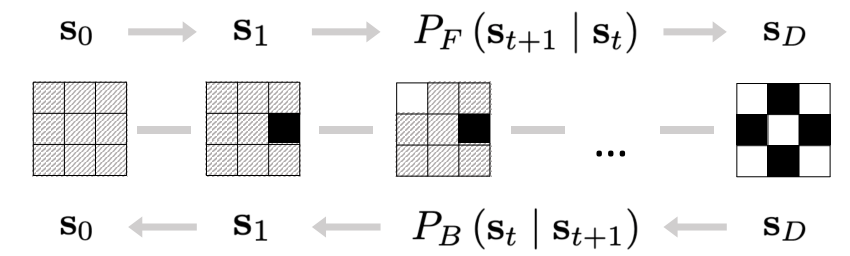

Image from [4]

Note that this description is valid just because during training, we choose to build our objects (i.e. we move from the initial state to the final state during training). But, since we have access to the modes in the reconstruction problem (the modes are the neighbors of $x$ in the metric space generated on $I$ by the distance we use in the reward function), we can decide to train the backward policy to sample the initial state from these modes (finals states with high reward), ie samples complete trajectories leading from the initial state to these modes, and force the forward policy to follow the opposite actions of the backward policy (what I call being its dual). Then, during inference, use this forward policy to sample the final states from the initial state. This process can extremely speed up the training.

In our case, to make things simple, the initial state is a completely black image (0), and at each step the model just has to choose the pixel to make white (1) or return the image as final state (stop action). The forward action space is reduced to $I \cup \{stop\_action \}$. If the forward policy has chosen a cell $(i, j) \in I$ and colored it (white, $1$), the backward policy must choose the same cell $(i, j)$ and decolorize it (black, $0$). The backward action space is then $I$.

We will use Euclidean distance, and we will choose $a$ depending on $M$ and $N$.

For small images (4x4, 5x5, ..., 10x10) it works well (the model returns the mode when we sample from it), but for 11x11 for example the model ''fails'' (it returns some modes, but not x). There is only one "true" mode in this case (x), but we define the modes by taking the images that have distance below a threshold.

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [ ]:
#M,N = 28, 28
#M,N = 10, 10
M,N = 6, 6
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(M,N)),
        lambda x : 1*(x!=0) + 0*(x==0),
])
data = MNIST(root='/content', download=True, train=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



torch.Size([1, 6, 6])


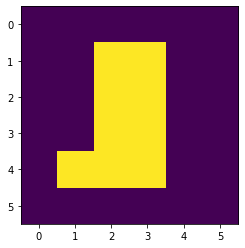

(<matplotlib.image.AxesImage at 0x7f10d8b71810>, None)

In [ ]:
import matplotlib.pyplot as plt

x = data[10][0]
print(x.shape)

plt.imshow(x.squeeze(0)),plt.show()

In [ ]:
x = x.view(x.shape[0], -1) # (1, 784)

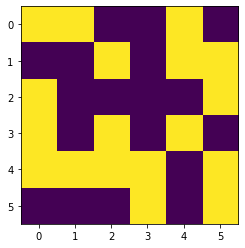

In [ ]:
import torch 
plt.imshow(torch.randint(low=0, high=2, size=(1, M,N)).squeeze(0))

In [ ]:
def make_mlp(l, act=torch.nn.LeakyReLU(), tail=[]):
    return torch.nn.Sequential(*(sum(
        [[torch.nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)

In [ ]:
n_hid = 256
n_layers = 2
ndim = M*N
input_dim = ndim # embedding dim
output_dim = 2*ndim+1 # ndim + 1 for P_F (+1 for stop action) and ndim for P_B 

#For GAN, it is better to learn a Z for each image and not a global Z as there.
independent_Z = False
if independent_Z:
    output_dim+=1
    logZ_TB = 0
    model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
    optimizer = torch.optim.Adam([ {'params':model_TB.parameters(), 'lr':0.001}])
else :
    logZ_TB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
    model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
    optimizer = torch.optim.Adam([ {'params':model_TB.parameters(), 'lr':0.001}, {'params':[logZ_TB], 'lr':0.1} ])
    logZ_TB.requires_grad_()

model_TB

Sequential(
  (0): Linear(in_features=36, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=73, bias=True)
)

In [ ]:
import tqdm
import numpy as np

In [ ]:
losses_TB = []
rewards_TB = []
logZ_TB_list = []
all_visited_TB = []

In [ ]:
n_train_steps = 10000
batch_size = 1
uniform_PB = False
minus_inf = -1e8

a = 100

  0%|          | 0/10000 [00:00<?, ?it/s]


loss = 512.6591186523438 logZ = -0.10000000149011612 R = 4.9890988e-20


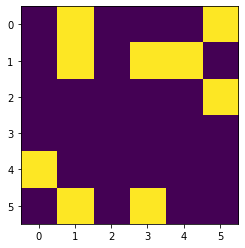

  1%|          | 99/10000 [00:09<12:31, 13.18it/s]


loss = 467.8556213378906 logZ = -7.15767765045166 R = 7.4563803e-25


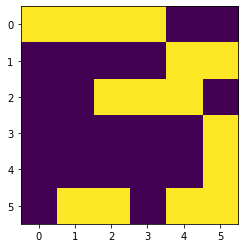

  2%|▏         | 197/10000 [00:15<10:41, 15.27it/s]


loss = 80.70758056640625 logZ = -12.277861595153809 R = 5.368969e-14


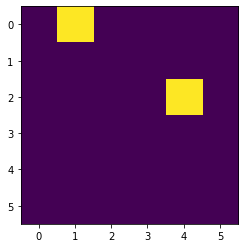

  3%|▎         | 298/10000 [00:22<08:17, 19.51it/s]


loss = 2.67977237701416 logZ = -14.20073127746582 R = 1.2905354e-17


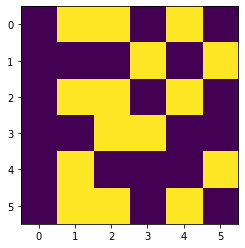

  4%|▍         | 399/10000 [00:26<07:15, 22.06it/s]


loss = 1.3996076583862305 logZ = -14.165170669555664 R = 5.368969e-14


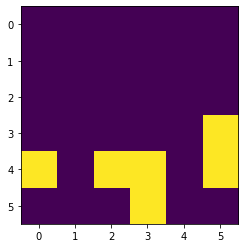

  5%|▌         | 500/10000 [00:32<05:16, 30.03it/s]


loss = 2.0482215881347656 logZ = -12.582322120666504 R = 5.7777417e-08


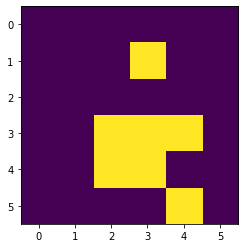

  6%|▌         | 599/10000 [00:35<05:25, 28.85it/s]


loss = 100.78427124023438 logZ = -12.082448959350586 R = 0.00024036932


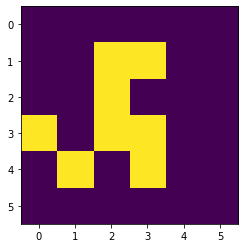

  7%|▋         | 698/10000 [00:39<07:01, 22.07it/s]


loss = 4.439117908477783 logZ = -11.341734886169434 R = 0.062176514


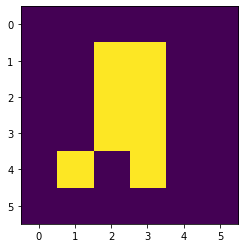

  8%|▊         | 799/10000 [00:44<07:07, 21.50it/s]


loss = 26.922605514526367 logZ = -10.089076042175293 R = 5.7777417e-08


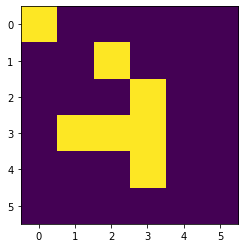

  9%|▉         | 900/10000 [00:49<07:12, 21.02it/s]


loss = 0.18853692710399628 logZ = -8.045300483703613 R = 0.003865919


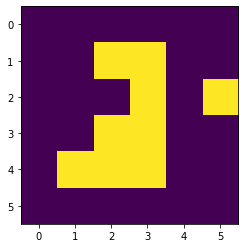

 10%|▉         | 999/10000 [00:53<06:57, 21.54it/s]


loss = 71.15153503417969 logZ = -6.860934734344482 R = 0.003865919


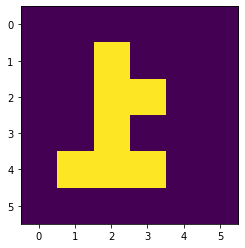

 11%|█         | 1098/10000 [00:58<06:45, 21.95it/s]


loss = 3.086512804031372 logZ = -5.577122688293457 R = 5.7777417e-08


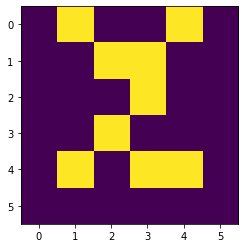

 12%|█▏        | 1198/10000 [01:03<07:21, 19.92it/s]


loss = 0.04760092496871948 logZ = -4.529385089874268 R = 0.003865919


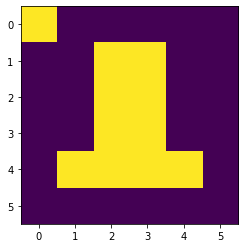

 13%|█▎        | 1300/10000 [01:09<07:15, 20.00it/s]


loss = 0.08809570223093033 logZ = -4.015066146850586 R = 0.00024036932


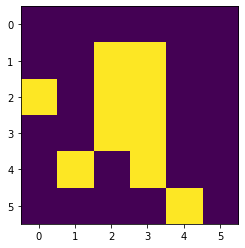

 14%|█▍        | 1399/10000 [01:14<06:57, 20.61it/s]


loss = 24.32484245300293 logZ = -3.6338181495666504 R = 0.062176514


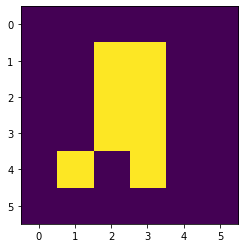

 15%|█▌        | 1500/10000 [01:20<06:54, 20.51it/s]


loss = 6.3147196769714355 logZ = -2.863300323486328 R = 0.062176514


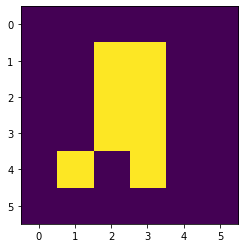

 16%|█▌        | 1600/10000 [01:25<06:57, 20.13it/s]


loss = 2.0999598503112793 logZ = -1.9609133005142212 R = 0.003865919


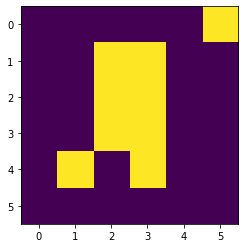

 17%|█▋        | 1700/10000 [01:30<07:21, 18.79it/s]


loss = 3.051518201828003 logZ = -1.0194141864776611 R = 0.00024036932


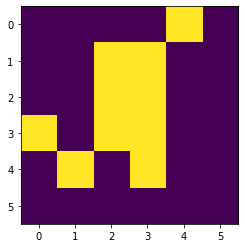

 18%|█▊        | 1799/10000 [01:36<07:34, 18.06it/s]


loss = 6.432326316833496 logZ = -0.3228550851345062 R = 0.062176514


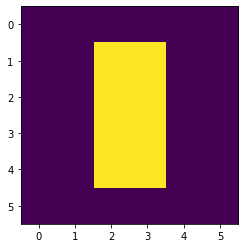

 19%|█▉        | 1899/10000 [01:42<06:56, 19.45it/s]


loss = 0.018489688634872437 logZ = 0.7707247734069824 R = 0.00024036932


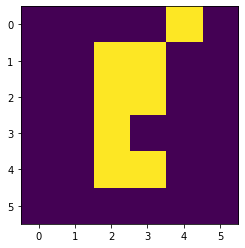

 20%|█▉        | 1999/10000 [01:49<16:38,  8.01it/s]


loss = 0.5152246952056885 logZ = 1.4689204692840576 R = 0.003865919


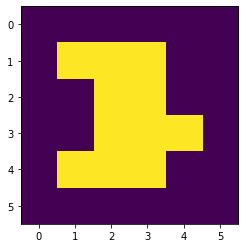

 21%|██        | 2099/10000 [01:57<13:54,  9.47it/s]


loss = 0.6809870600700378 logZ = 1.5550636053085327 R = 0.062176514


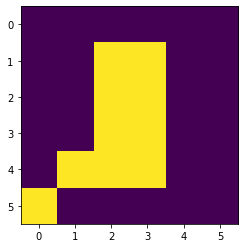

 22%|██▏       | 2199/10000 [02:05<07:42, 16.86it/s]


loss = 0.36317571997642517 logZ = 1.6540247201919556 R = 0.062176514


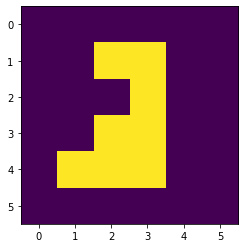

 23%|██▎       | 2299/10000 [02:11<07:14, 17.74it/s]


loss = 0.7421892881393433 logZ = 1.956602692604065 R = 0.062176514


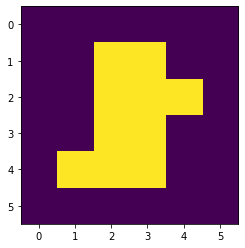

 24%|██▍       | 2399/10000 [02:17<07:35, 16.70it/s]


loss = 0.49145209789276123 logZ = 1.855776309967041 R = 0.003865919


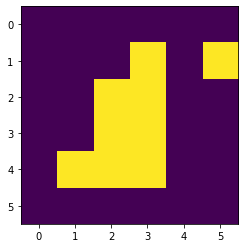

 25%|██▌       | 2500/10000 [02:24<12:20, 10.13it/s]


loss = 0.41346263885498047 logZ = 1.8781675100326538 R = 0.003865919


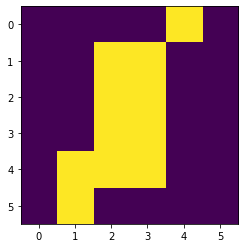

 26%|██▌       | 2599/10000 [02:32<08:46, 14.07it/s]


loss = 0.4666852056980133 logZ = 1.8828063011169434 R = 0.00024036932


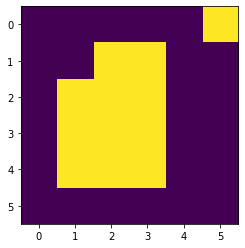

 27%|██▋       | 2699/10000 [02:38<12:08, 10.02it/s]


loss = 0.9387232661247253 logZ = 1.9532827138900757 R = 0.003865919


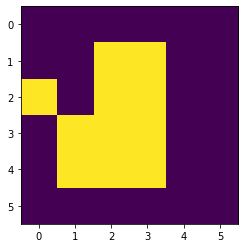

 28%|██▊       | 2798/10000 [02:45<07:10, 16.72it/s]


loss = 1.943284034729004 logZ = 1.8831965923309326 R = 1.494533e-05


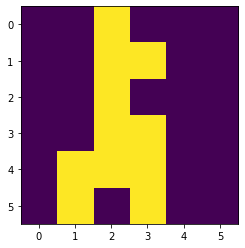

 29%|██▉       | 2899/10000 [02:50<07:10, 16.51it/s]


loss = 0.7061401009559631 logZ = 1.9377720355987549 R = 0.062176514


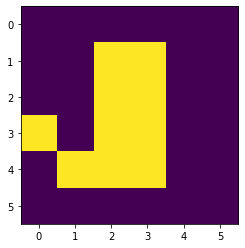

 30%|███       | 3000/10000 [02:57<06:51, 17.00it/s]


loss = 0.05804408714175224 logZ = 1.993329405784607 R = 0.003865919


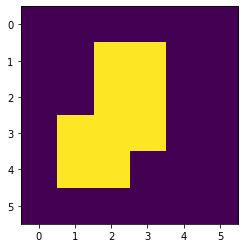

 31%|███       | 3099/10000 [03:02<06:57, 16.52it/s]


loss = 1.0305393934249878 logZ = 2.057600736618042 R = 5.7777417e-08


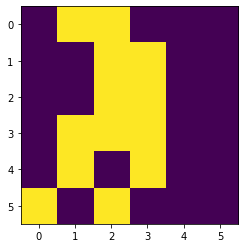

 32%|███▏      | 3199/10000 [03:08<06:21, 17.81it/s]


loss = 0.5999446511268616 logZ = 1.6631559133529663 R = 0.003865919


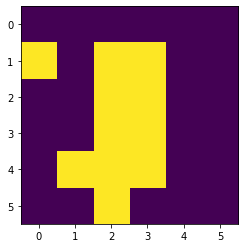

 33%|███▎      | 3300/10000 [03:15<07:28, 14.95it/s]


loss = 0.5750818252563477 logZ = 1.8955271244049072 R = 1.0


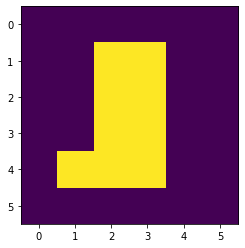

 34%|███▍      | 3400/10000 [03:21<05:53, 18.67it/s]


loss = 0.09065576642751694 logZ = 2.0919559001922607 R = 0.062176514


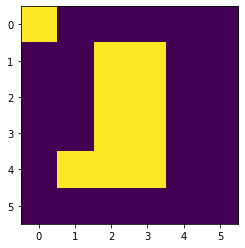

 35%|███▌      | 3500/10000 [03:27<06:20, 17.10it/s]


loss = 0.5144419074058533 logZ = 1.971221923828125 R = 1.494533e-05


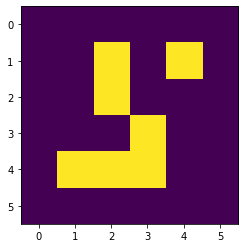

 36%|███▌      | 3600/10000 [03:33<06:18, 16.90it/s]


loss = 0.01736217364668846 logZ = 1.980860710144043 R = 0.062176514


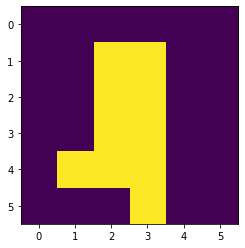

 37%|███▋      | 3700/10000 [03:39<06:06, 17.17it/s]


loss = 0.353585422039032 logZ = 1.971509337425232 R = 0.062176514


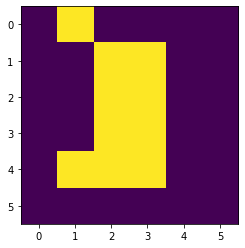

 38%|███▊      | 3799/10000 [03:45<06:07, 16.85it/s]


loss = 0.018329495564103127 logZ = 2.122718572616577 R = 0.062176514


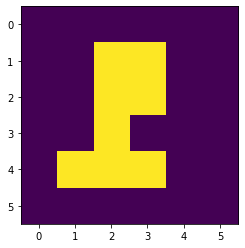

 39%|███▉      | 3899/10000 [03:51<06:16, 16.20it/s]


loss = 0.2346440851688385 logZ = 1.9927643537521362 R = 9.292488e-07


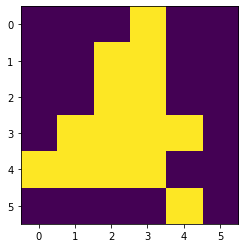

 40%|████      | 4000/10000 [03:57<06:09, 16.24it/s]


loss = 0.7721426486968994 logZ = 1.9002652168273926 R = 1.494533e-05


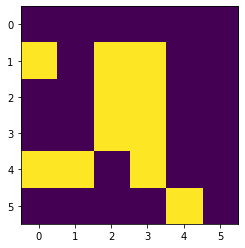

 41%|████      | 4100/10000 [04:03<05:17, 18.60it/s]


loss = 0.0011555254459381104 logZ = 1.9683557748794556 R = 1.0


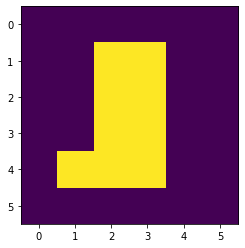

 42%|████▏     | 4200/10000 [04:09<05:33, 17.39it/s]


loss = 0.2977183163166046 logZ = 2.0399985313415527 R = 0.00024036932


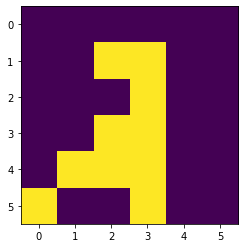

 43%|████▎     | 4299/10000 [04:15<05:31, 17.21it/s]


loss = 0.24043473601341248 logZ = 1.9770630598068237 R = 1.0


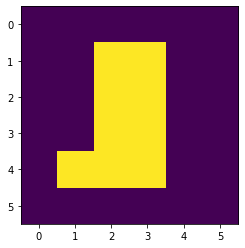

 44%|████▍     | 4399/10000 [04:22<05:51, 15.94it/s]


loss = 0.04254543408751488 logZ = 1.9164940118789673 R = 0.00024036932


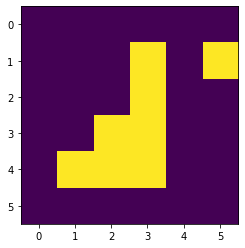

 45%|████▍     | 4499/10000 [04:28<05:10, 17.72it/s]


loss = 0.00010994883632520214 logZ = 2.156998634338379 R = 0.062176514


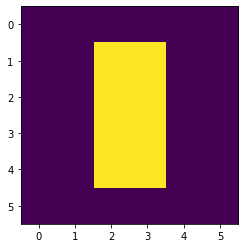

 46%|████▌     | 4599/10000 [04:34<04:51, 18.55it/s]


loss = 0.012078847736120224 logZ = 2.038860321044922 R = 0.003865919


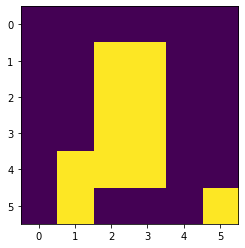

 47%|████▋     | 4700/10000 [04:40<05:09, 17.12it/s]


loss = 0.9808588027954102 logZ = 1.7169541120529175 R = 0.00024036932


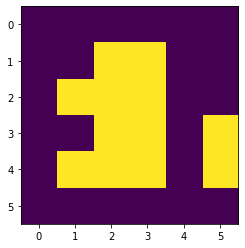

 48%|████▊     | 4800/10000 [04:46<04:42, 18.41it/s]


loss = 0.3925711214542389 logZ = 1.864484190940857 R = 0.062176514


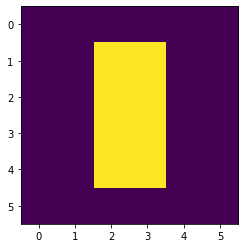

 49%|████▉     | 4899/10000 [04:52<04:30, 18.84it/s]


loss = 1.0991688966751099 logZ = 1.957149863243103 R = 0.062176514


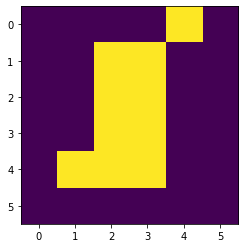

 50%|█████     | 5000/10000 [04:58<04:35, 18.16it/s]


loss = 0.002156264381483197 logZ = 2.01462459564209 R = 0.062176514


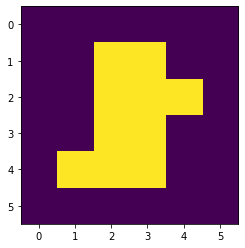

 51%|█████     | 5100/10000 [05:04<04:43, 17.29it/s]


loss = 0.39482223987579346 logZ = 1.9922047853469849 R = 0.003865919


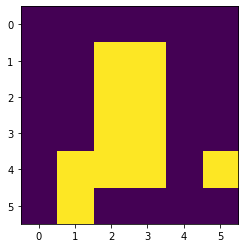

 52%|█████▏    | 5200/10000 [05:10<04:25, 18.06it/s]


loss = 2.2336696929414757e-05 logZ = 1.9165253639221191 R = 0.062176514


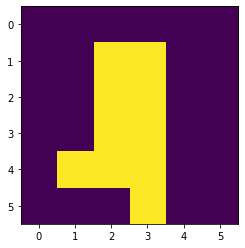

 53%|█████▎    | 5299/10000 [05:16<04:54, 15.98it/s]


loss = 0.07862699031829834 logZ = 2.1438496112823486 R = 0.062176514


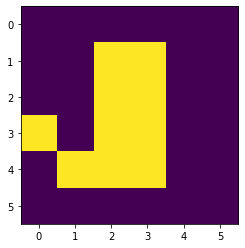

 54%|█████▍    | 5399/10000 [05:22<04:22, 17.50it/s]


loss = 1.7122266292572021 logZ = 2.019627094268799 R = 0.003865919


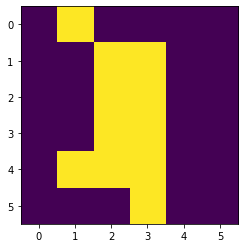

 55%|█████▍    | 5499/10000 [05:28<04:44, 15.80it/s]


loss = 0.6549355387687683 logZ = 1.7839223146438599 R = 0.00024036932


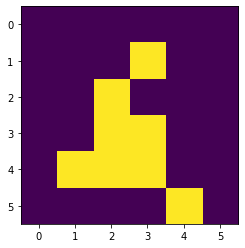

 56%|█████▌    | 5599/10000 [05:34<04:28, 16.42it/s]


loss = 0.24828775227069855 logZ = 1.88702392578125 R = 0.003865919


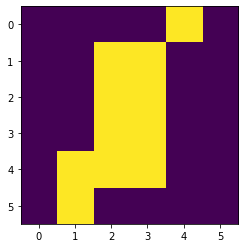

 57%|█████▋    | 5700/10000 [05:40<04:18, 16.64it/s]


loss = 0.13230225443840027 logZ = 1.7966036796569824 R = 0.003865919


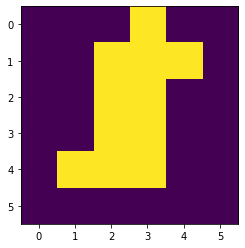

 58%|█████▊    | 5800/10000 [05:46<04:16, 16.39it/s]


loss = 0.019952476024627686 logZ = 1.8560327291488647 R = 0.062176514


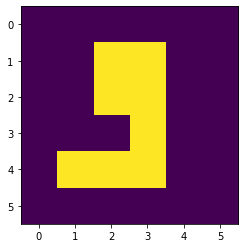

 59%|█████▉    | 5900/10000 [05:52<03:56, 17.34it/s]


loss = 0.14374490082263947 logZ = 1.8825818300247192 R = 0.00024036932


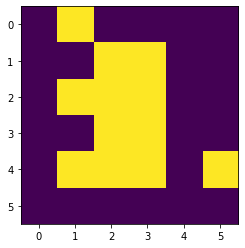

 60%|█████▉    | 5999/10000 [05:58<03:21, 19.83it/s]


loss = 0.10560039430856705 logZ = 1.7303539514541626 R = 0.003865919


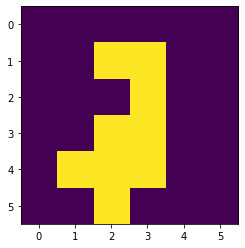

 61%|██████    | 6100/10000 [06:05<03:55, 16.53it/s]


loss = 0.13774384558200836 logZ = 2.0305707454681396 R = 0.003865919


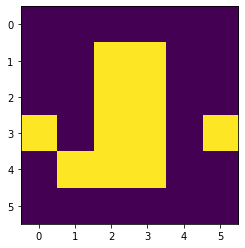

 62%|██████▏   | 6200/10000 [06:11<03:32, 17.85it/s]


loss = 0.03627481684088707 logZ = 2.1307806968688965 R = 0.062176514


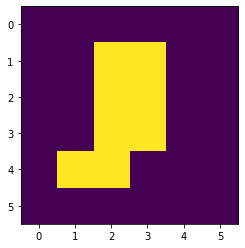

 63%|██████▎   | 6298/10000 [06:18<03:30, 17.55it/s]


loss = 0.05710337683558464 logZ = 1.4079080820083618 R = 1.494533e-05


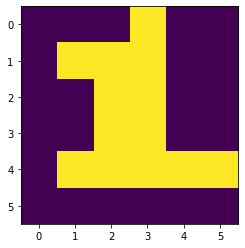

 64%|██████▍   | 6399/10000 [06:24<03:44, 16.04it/s]


loss = 0.30454009771347046 logZ = 1.6067792177200317 R = 0.062176514


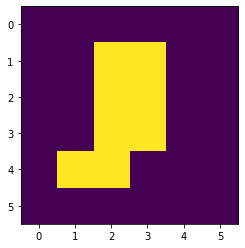

 65%|██████▌   | 6500/10000 [06:31<03:34, 16.31it/s]


loss = 0.05676795542240143 logZ = 1.9894821643829346 R = 0.003865919


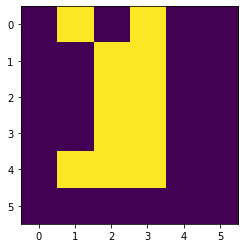

 66%|██████▌   | 6599/10000 [06:37<03:26, 16.49it/s]


loss = 0.07968252152204514 logZ = 1.7924302816390991 R = 0.00024036932


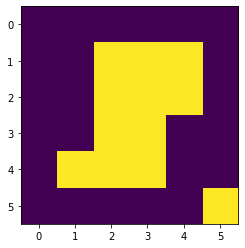

 67%|██████▋   | 6700/10000 [06:43<03:27, 15.94it/s]


loss = 1.062090277671814 logZ = 2.128617286682129 R = 1.494533e-05


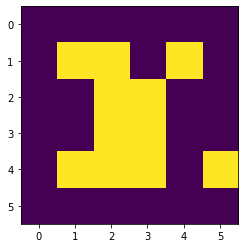

 68%|██████▊   | 6800/10000 [06:49<03:08, 16.96it/s]


loss = 0.010331026278436184 logZ = 1.7289063930511475 R = 0.062176514


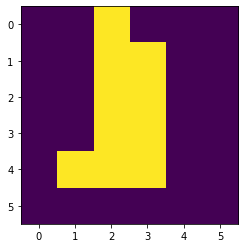

 69%|██████▉   | 6900/10000 [06:56<05:30,  9.37it/s]


loss = 0.17409968376159668 logZ = 1.6783418655395508 R = 0.00024036932


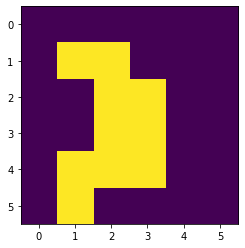

 70%|███████   | 7000/10000 [07:03<02:55, 17.08it/s]


loss = 0.2784833312034607 logZ = 2.1689364910125732 R = 0.062176514


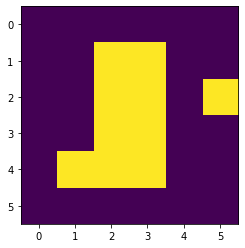

 71%|███████   | 7100/10000 [07:09<02:49, 17.14it/s]


loss = 3.379459857940674 logZ = 1.6436216831207275 R = 0.003865919


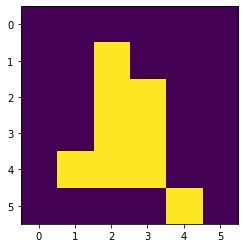

 72%|███████▏  | 7199/10000 [07:15<02:38, 17.62it/s]


loss = 0.1463485211133957 logZ = 1.8045070171356201 R = 0.062176514


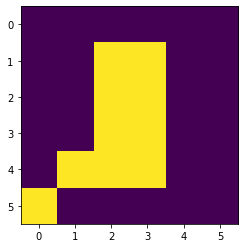

 73%|███████▎  | 7300/10000 [07:23<02:47, 16.13it/s]


loss = 0.10468752682209015 logZ = 1.6259342432022095 R = 0.003865919


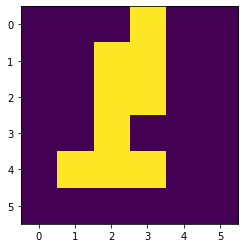

 74%|███████▍  | 7400/10000 [07:29<02:30, 17.29it/s]


loss = 0.19831766188144684 logZ = 2.025891065597534 R = 0.00024036932


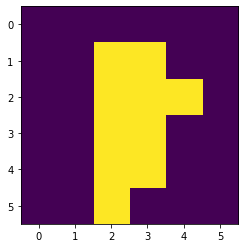

 75%|███████▌  | 7500/10000 [07:35<02:29, 16.77it/s]


loss = 0.19503064453601837 logZ = 2.200392961502075 R = 0.00024036932


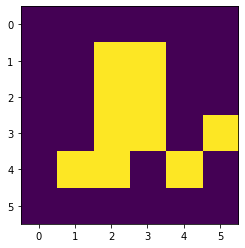

 76%|███████▌  | 7599/10000 [07:42<02:17, 17.46it/s]


loss = 1.17179274559021 logZ = 2.0357346534729004 R = 0.062176514


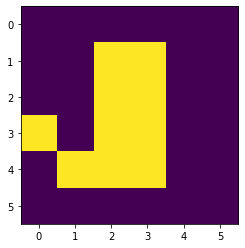

 77%|███████▋  | 7700/10000 [07:48<02:19, 16.53it/s]


loss = 0.14211702346801758 logZ = 1.7746753692626953 R = 0.00024036932


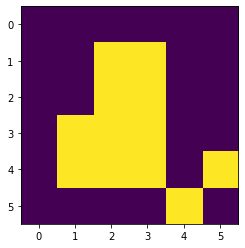

 78%|███████▊  | 7800/10000 [07:54<02:07, 17.21it/s]


loss = 0.018170539289712906 logZ = 2.140127658843994 R = 1.0


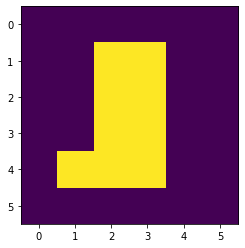

 79%|███████▉  | 7899/10000 [08:00<02:08, 16.29it/s]


loss = 0.30930331349372864 logZ = 2.543339967727661 R = 2.2336291e-10


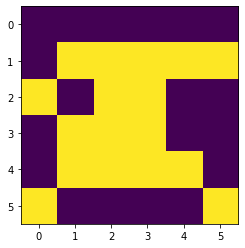

 80%|████████  | 8000/10000 [08:08<01:56, 17.18it/s]


loss = 1.2233339548110962 logZ = 1.9777226448059082 R = 0.003865919


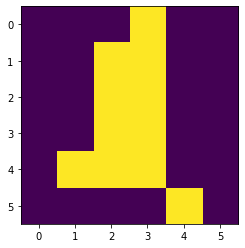

 81%|████████  | 8099/10000 [08:14<01:51, 17.06it/s]


loss = 0.06820723414421082 logZ = 2.096052646636963 R = 0.062176514


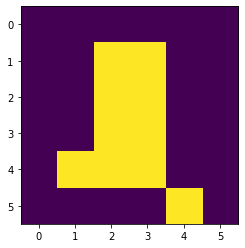

 82%|████████▏ | 8200/10000 [08:21<01:56, 15.46it/s]


loss = 1.1995435953140259 logZ = 1.9258085489273071 R = 0.00024036932


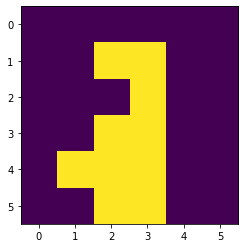

 83%|████████▎ | 8299/10000 [08:29<01:39, 17.02it/s]


loss = 0.08450424671173096 logZ = 1.368445634841919 R = 0.00024036932


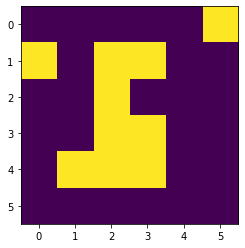

 84%|████████▍ | 8399/10000 [08:36<02:28, 10.81it/s]


loss = 0.02852088212966919 logZ = 1.6641992330551147 R = 1.0


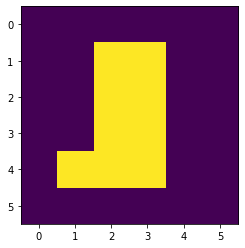

 85%|████████▍ | 8499/10000 [08:44<01:28, 16.91it/s]


loss = 0.4378869831562042 logZ = 1.834989070892334 R = 0.003865919


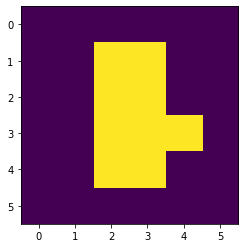

 86%|████████▌ | 8600/10000 [08:53<02:01, 11.54it/s]


loss = 0.0833466500043869 logZ = 1.8649271726608276 R = 0.003865919


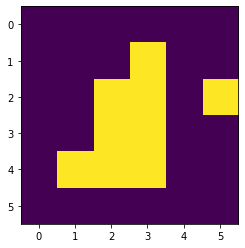

 87%|████████▋ | 8699/10000 [09:01<02:11,  9.89it/s]


loss = 0.006436355412006378 logZ = 1.8378021717071533 R = 0.062176514


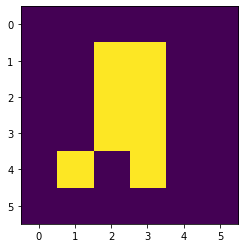

 88%|████████▊ | 8799/10000 [09:08<01:13, 16.41it/s]


loss = 5.784285068511963 logZ = 1.905197024345398 R = 5.7777417e-08


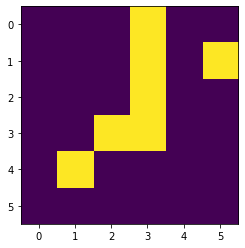

 89%|████████▉ | 8899/10000 [09:14<01:08, 16.03it/s]


loss = 0.09091394394636154 logZ = 2.0152015686035156 R = 0.003865919


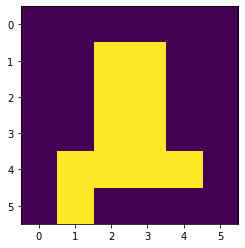

 90%|█████████ | 9000/10000 [09:20<00:58, 16.97it/s]


loss = 0.004173632245510817 logZ = 1.9762988090515137 R = 1.0


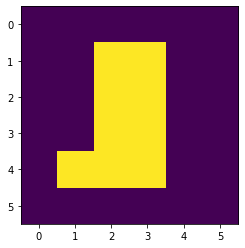

 91%|█████████ | 9100/10000 [09:27<00:49, 18.17it/s]


loss = 0.05510343611240387 logZ = 1.8547438383102417 R = 0.003865919


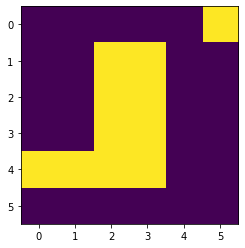

 92%|█████████▏| 9200/10000 [09:33<00:49, 16.02it/s]


loss = 0.12681694328784943 logZ = 2.0469653606414795 R = 0.062176514


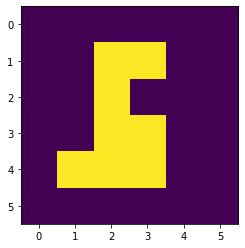

 93%|█████████▎| 9300/10000 [09:39<00:39, 17.71it/s]


loss = 0.48829758167266846 logZ = 2.1457130908966064 R = 0.00024036932


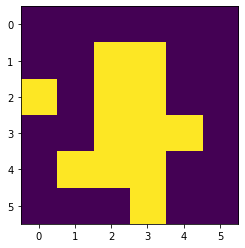

 94%|█████████▍| 9400/10000 [09:45<00:36, 16.47it/s]


loss = 0.30066978931427 logZ = 2.1759448051452637 R = 0.00024036932


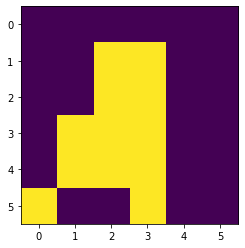

 95%|█████████▍| 9499/10000 [09:51<00:31, 15.76it/s]


loss = 0.0024971975944936275 logZ = 1.929572343826294 R = 1.0


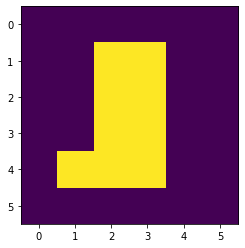

 96%|█████████▌| 9599/10000 [09:58<00:26, 15.32it/s]


loss = 0.12214137613773346 logZ = 1.9268975257873535 R = 0.00024036932


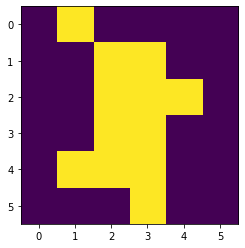

 97%|█████████▋| 9699/10000 [10:04<00:19, 15.71it/s]


loss = 0.0274082999676466 logZ = 2.1169180870056152 R = 0.062176514


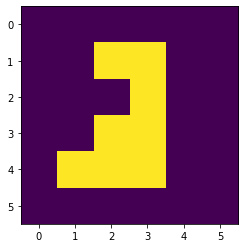

 98%|█████████▊| 9800/10000 [10:11<00:12, 16.58it/s]


loss = 0.061547596007585526 logZ = 1.7290458679199219 R = 1.494533e-05


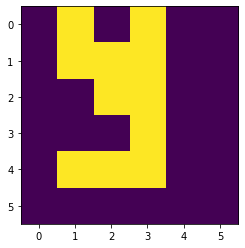

 99%|█████████▉| 9900/10000 [10:17<00:05, 16.68it/s]


loss = 0.036688029766082764 logZ = 1.827315092086792 R = 0.062176514


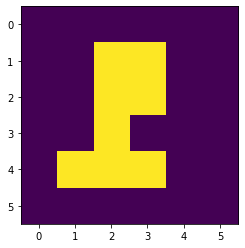

100%|██████████| 10000/10000 [10:23<00:00, 16.03it/s]


In [ ]:
for it in tqdm.trange(n_train_steps):    
    # TB loss for each trajectory
    loss_TB = torch.zeros((batch_size,)).to(device)
    loss_TB += 0 if independent_Z else logZ_TB # see the equation above
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros(size=(batch_size, ndim)).to(device) # (batch_size, ndim)
    # actions chosen at each step 
    actions = None # (current_batch_size,)

    max_steps = 1e8 #ndim+0
    i = 0
    while torch.any(~dones) and i <= max_steps :
        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        logits = model_TB(non_terminal_states) # (current_batch_size, output_dim)

        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Cells that are still black (0) are excluded from the action space of the backward policy
        PB_mask = (non_terminal_states == 0.).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*PB_mask).log_softmax(1) # (current_batch_size, ndim)
        if actions is not None: 
            loss_TB[~dones] -= logPB.gather(1, actions[actions!=ndim].unsqueeze(1)).squeeze(1)
        elif independent_Z :
            logZ_TB = logits[...,-1]
            loss_TB += logZ_TB + 0 
            logZ_TB = logZ_TB.mean()

        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Cells that are already white (1) are excluded from the action space of the forward policy
        edge_mask = (non_terminal_states == 1.).float() # (current_batch_size, ndim)
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        sample_temperature = 1
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        loss_TB[~dones] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            all_visited_TB.append(state)
       
       # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories
        with torch.no_grad():
            non_terminates = actions[~terminates].squeeze()
            tmp = states[~dones]
            tmp[torch.arange((~dones).sum()), non_terminates] = 1.
            states[~dones] = tmp
        
        i+=1
        
    dist = torch.nn.functional.mse_loss(input=states.view(M,N), target=x.view(M,N))
    R = (-a*dist).exp()
    loss_TB -= R.log()
    loss = (loss_TB**2).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_TB.append(loss.item())
    rewards_TB.append(R.mean().cpu())
    logZ_TB_list.append(logZ_TB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_TB[-1:]).mean(), 'logZ =', logZ_TB.item(), "R =", np.array(rewards_TB[-1:]).mean())
        plt.imshow(states.view(M,N).cpu()), plt.show()

tensor(0.1389, device='cuda:0') tensor(9.2925e-07, device='cuda:0')


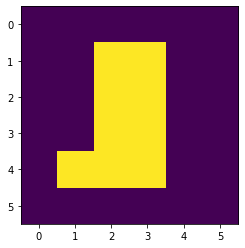

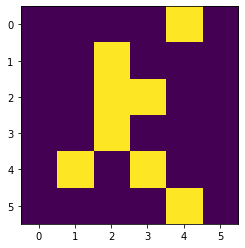

(<matplotlib.image.AxesImage at 0x7f10d4a3c490>, None)

In [ ]:
dist = torch.nn.functional.mse_loss(input=states.view(M,N), target=x.view(M,N))
R = (-a*dist).exp()
print(dist, R)

plt.imshow(x.view(M,N).cpu()), plt.show()
plt.imshow(states.view(M,N).cpu()), plt.show()

Samples

In [ ]:
all_images = []
all_R = []
all_dist = []
for it in tqdm.trange(100):    
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros(size=(batch_size, ndim)).to(device) # (batch_size, ndim)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    max_steps = 1e8 #ndim+0
    i = 0
    while torch.any(~dones) and i <= max_steps :
        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        logits = model_TB(non_terminal_states) # (current_batch_size, output_dim)
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        edge_mask = (non_terminal_states == 1.).float() # (current_batch_size, ndim)
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        sample_temperature = 1
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            all_visited_TB.append(state)
       
       # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories$
        with torch.no_grad():
            non_terminates = actions[~terminates].squeeze()
            tmp = states[~dones]
            tmp[torch.arange((~dones).sum()), non_terminates] = 1.
            states[~dones] = tmp
        
        i+=1
        
    dist = torch.nn.functional.mse_loss(input=states.view(M,N), target=x.view(M,N))
    R = (-a*dist).exp()
    
    all_images.append(states.view(M,N).cpu())
    all_R.append(R.item())
    all_dist.append(dist.item())

100%|██████████| 100/100 [00:02<00:00, 37.58it/s]


In [ ]:
tp = torch.tensor(all_R).topk(k=10)
values = tp.values
indices = tp.indices

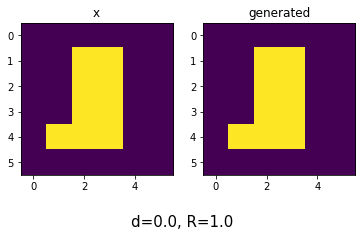

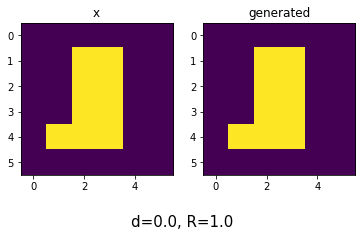

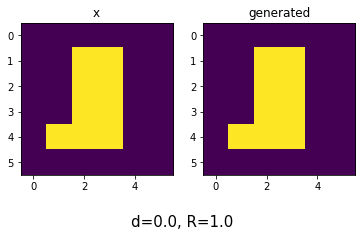

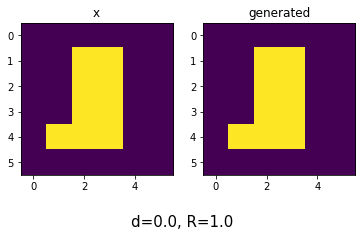

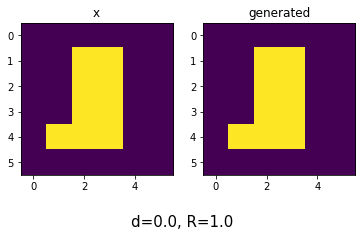

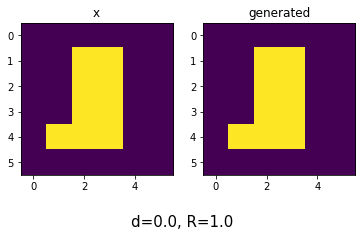

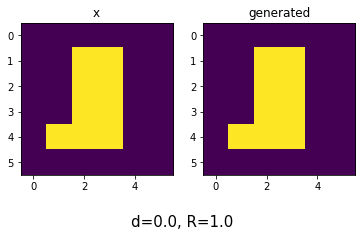

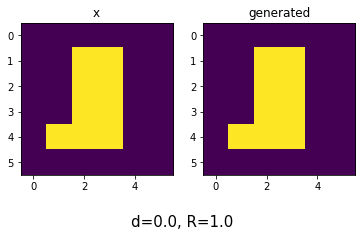

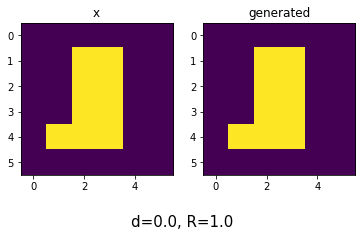

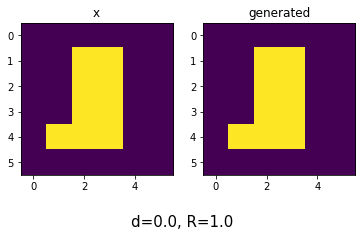

In [ ]:
for i in indices:
    fig, axarr = plt.subplots(1,2)
    fig.suptitle("d=%s, R=%s"%(all_dist[i], all_R[i]), x=0.5, y=0.1, fontsize=15)
    axarr[0].imshow(x.view(M,N).cpu())
    axarr[0].set_title('x')
    axarr[1].imshow(all_images[i].view(M,N).cpu())
    axarr[1].set_title('generated')

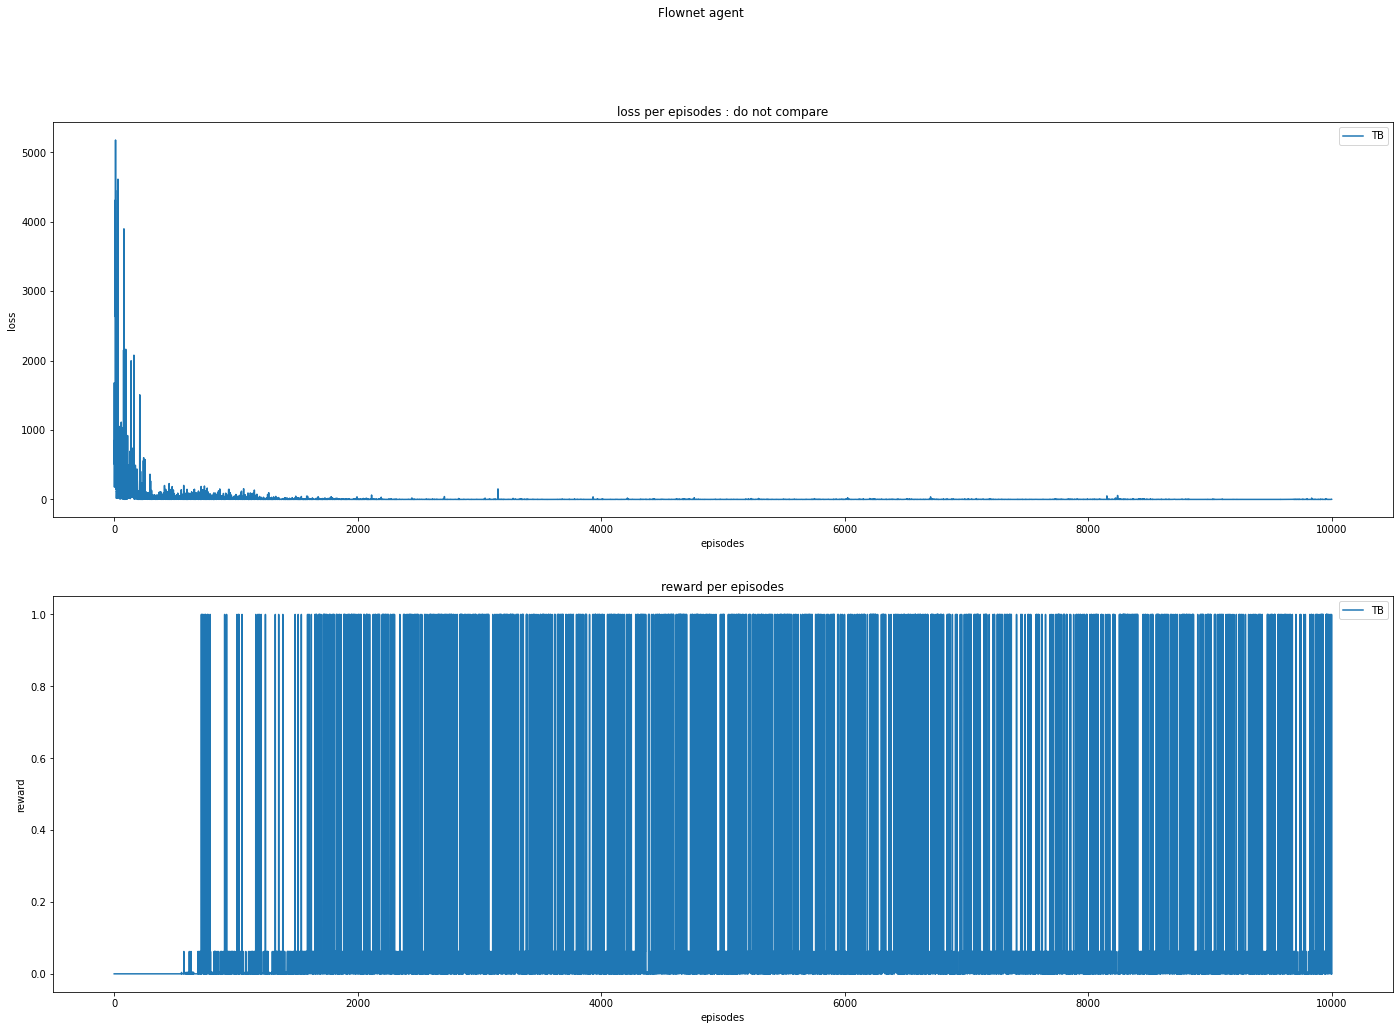

In [ ]:
figsize=(6*4,4*4)
fig, (ax1, ax2)  = plt.subplots(2, 1, sharex=False, sharey=False, figsize = figsize)
fig.suptitle("Flownet agent")

## loss
xs_TB = list(range(len(losses_TB)))
ax1.plot(xs_TB, losses_TB, label="TB")
ax1.set(xlabel='episodes', ylabel='loss')
ax1.set_title('loss per episodes : do not compare')
ax1.legend()

## rewards
ax2.plot(xs_TB, rewards_TB, label="TB")
ax2.set(xlabel='episodes', ylabel='reward')
ax2.set_title('reward per episodes')
ax2.legend()

# GAN (Goodfellow et al., 2014) 

I took this GAN base code here : https://github.com/ikr7/wandb-pytorch-gan-mnist-demo


dataset : MNIST,  28x28

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

def bin_transform(x) :
    return 1.*(x!=0) + 0.*(x==0)

M,N = 28, 28
def get_mnist(bin = False):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(M,N)),
        transforms.Normalize(mean=(0.5,), std=(0.5,)) if not bin else bin_transform,
    ])
    return MNIST(root='/content', download=True, train=True, transform=transform)

models

In [ ]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

def block (n_in_channels, n_out_channels, batch_norm=True):
    layers = []
    layers.append(nn.Linear(n_in_channels, n_out_channels))
    if batch_norm:
        layers.append(nn.BatchNorm1d(n_out_channels, 0.8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

class Generator(nn.Module):
    def __init__(self, nz, bin = False):

        super(Generator, self).__init__()

        self.main = nn.Sequential(
            *block(nz, 256, batch_norm=False),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, M*N),
            nn.Sigmoid() if bin else nn.Tanh()
        )

    def forward(self, z):
        fake_image = self.main(z)
        return fake_image.view(fake_image.size(0), 1, M, N)

    def predict(self, z):
        fake_image = self.main(z)
        return fake_image.view(fake_image.size(0), 1, M, N)

class Discriminator(nn.Module):
    def __init__(self):

        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            Flatten(),
            nn.Linear(M*N, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

train

In [ ]:
## Uncomment if you want to use wandb ##
#!pip install wandb

In [ ]:
## Uncomment if you want to use wandb ##
# #wandb.login()
# %env wand_db_key="PASTE YOURS"
# !wandb login $wand_db_key

# import wandb

In [ ]:
import torch
import argparse
from pathlib import Path

import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

Uncomment this part to train a GAN, or go to the next section for GAN-GflowNets

In [ ]:
params = AttrDict({
    # number of epochs 
    "num_epochs": 250,
    # batch size
    "batch_size": 1024,
    # dimensionality of the latent space
    "nz": 100,
    # learning rate for discriminator
    "d_lr": 0.0002,
    # learning rate for generator
    "g_lr": 0.0002, 
    # use a GPU or not
    "cuda": torch.cuda.is_available(),
    # where to save network snapshots
    "log_dir": '/content/',
    # binary image
    "bin" : True,
})

dataset = get_mnist(bin=params["bin"])
dataloader = DataLoader(
    dataset,
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=4,
    drop_last=True
)

device = torch.device('cuda:0' if params['cuda'] else 'cpu')

In [ ]:
## Uncomment if you want to use wandb ##
# wandb.init(project='gan-mnist', config=params)
# run_id = wandb.run.id
# run_log_dir = Path(params['log_dir']) / run_id
# run_log_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
d_net = Discriminator().to(device)
g_net = Generator(nz=params['nz'], bin=params["bin"]).to(device)

# Uncomment if you want to use wandb ##
# wandb.watch(d_net)
# wandb.watch(g_net)

bce = nn.BCELoss(reduction = 'mean')

d_opt = torch.optim.Adam(d_net.parameters(), lr=params['d_lr'], betas=(0.5, 0.999))
g_opt = torch.optim.Adam(g_net.parameters(), lr=params['g_lr'], betas=(0.5, 0.999))

fixed_noise = torch.randn(64, params['nz']).to(device)

In [ ]:
for epoch in tqdm(range(1, params['num_epochs'] + 1), desc='Training'):

    d_net.train()
    g_net.train()

    total_g_loss_train = 0
    total_d_real_loss_train = 0
    total_d_fake_loss_train = 0
    total_d_loss_train = 0

    for i, (real_image, _) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch :4d}', leave=False), 1):

        noise = torch.randn(params['batch_size'], params['nz']).to(device)

        real_image = real_image.to(device)
        fake_image = g_net(noise)

        real_label = torch.ones(params['batch_size'], 1).to(device)
        fake_label = torch.zeros(params['batch_size'], 1).to(device)

        g_net.zero_grad()
        g_loss = bce(d_net(fake_image), real_label)
        total_g_loss_train += g_loss.item()
        g_loss.backward()
        g_opt.step()

        d_net.zero_grad()
        d_real_loss = bce(d_net(real_image), real_label)
        d_fake_loss = bce(d_net(fake_image.detach()), fake_label)
        d_loss = d_real_loss + d_fake_loss
        total_d_real_loss_train += d_real_loss.item()
        total_d_fake_loss_train += d_fake_loss.item()
        total_d_loss_train += d_loss.item()
        d_loss.backward()
        d_opt.step()
    
    g_loss_train = total_g_loss_train / len(dataloader)
    d_real_loss_train = total_d_real_loss_train / len(dataloader)
    d_fake_loss_train = total_d_fake_loss_train / len(dataloader)
    d_loss_train = total_d_loss_train / len(dataloader)

    g_net.eval()
    with torch.no_grad():
        fixed_fake_image = g_net.predict(fixed_noise).detach()

    data = {
         'g_loss_train': g_loss_train,
         'd_real_loss_train': d_real_loss_train,
         'd_fake_loss_train': d_fake_loss_train,
         'd_loss_train': d_loss_train
    }

    ## Uncomment if you want to use wandb ##
    #data['examples'] =  [wandb.Image(i) for i in fixed_fake_image]
    #data["reals"] = [wandb.Image(i) for i in real_image]
    #wandb.log(data)

    #torch.save(g_net.state_dict(), run_log_dir / f'generator-{epoch :04d}.pth')
    #torch.save(d_net.state_dict(), run_log_dir / f'discriminator-{epoch :04d}.pth')
    
    run_log_dir = "/content"
    torch.save(g_net.state_dict(), run_log_dir+"/"+ f'generator-{epoch :04d}.pth')
    torch.save(d_net.state_dict(), run_log_dir+"/"+ f'discriminator-{epoch :04d}.pth')


    if epoch%1 == 0:
        plt.imshow(fake_image[0][0].detach().cpu()), plt.show()
        for k, v in data.items():
            if k != "examples": print(k, v)



---

# GAN GflowNet
The Generator generates the images as I described above, and the reward is calculated that way : $R(x = Generator()) = e^{- \big[ binary\_cross\_entropy\_loss \big( Discriminator(x), \ real\_label \big) \big] }$

With good hyperparameters and on small images the results are acceptable.

In [ ]:
class GeneratorFlowNet(nn.Module):
    def __init__(self, model_TB, logZ_TB, independent_Z, uniform_PB = False):

        super(GeneratorFlowNet, self).__init__()

        self.model_TB = model_TB
        self.logZ_TB = 0 if independent_Z else logZ_TB
        self.independent_Z = independent_Z
        self.uniform_PB = uniform_PB
    
    def forward(self, z):
        batch_size = z.size(0)
        device = z.device
        ndim = M*N
        minus_inf = -1e8

        # TB loss for each trajectory
        loss_TB = torch.zeros((batch_size,)).to(device)
        loss_TB += self.logZ_TB # see the equation above
        # finished trajectories
        dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
        # s_0
        states = torch.zeros(size=(batch_size, ndim)).to(device) # (batch_size, ndim)
        # actions chosen at each step 
        actions = None # (current_batch_size,)

        max_steps = ndim*1e8
        i = 0
        while torch.any(~dones) and i <= max_steps :
            ### Forward pass ### 
            current_batch_size = (~dones).sum()
            non_terminal_states = states[~dones] # (current_batch_size, ndim)
            logits = self.model_TB(non_terminal_states) # (current_batch_size, output_dim)

            ### Backward Policy ### 
            PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
            PB_logits = PB_logits * (0 if self.uniform_PB else 1) # (current_batch_size, ndim)
            PB_mask = (non_terminal_states == 0.).float() # (current_batch_size, ndim)
            logPB = (PB_logits + minus_inf*PB_mask).log_softmax(1) # (current_batch_size, ndim)

            is_initial = actions is None
            if not is_initial : 
                loss_TB[~dones] -= logPB.gather(1, actions[actions!=ndim].unsqueeze(1)).squeeze(1)
            else :
                logZ_TB = logits[...,-1]
                loss_TB += logZ_TB # see the equation above

            ### Forward Policy ### 
            PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
            edge_mask = (non_terminal_states == 1.).float() # (current_batch_size, ndim)
            stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
            #stop_action_mask = torch.ones((current_batch_size, 1), device=device) # (current_batch_size, 1)
            PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
            logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
            sample_temperature = 1 # 0.5
            sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
            actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
            loss_TB[~dones] += logPF.gather(1, actions).squeeze(1)

            ### select terminal states ### 
            terminates = (actions==ndim).squeeze(1)
          
            # Update dones
            dones[~dones] |= terminates

            # Update non completed trajectories$
            with torch.no_grad():
                non_terminates = actions[~terminates].squeeze()
                tmp = states[~dones]
                tmp[torch.arange((~dones).sum()), non_terminates] = 1.
                states[~dones] = tmp
            
            i+=1
            
        return states.view(batch_size, 1, M,N), loss_TB, logZ_TB if self.independent_Z else self.logZ_TB

    def predict(self, z):
        with torch.no_grad():
            fake_image, loss_TB, logZ_TB = self.forward(z)
        return fake_image

In [ ]:
params = AttrDict({
    # number of epochs 
    "num_epochs": 250,
    # batch size
    "batch_size": 1024,
    # dimensionality of the latent space
    "nz": 100,
    # learning rate for discriminator
    "d_lr": 0.0002,
    # learning rate for generator
    "g_lr": 0.0002, 
    # use a GPU or not
    "cuda": torch.cuda.is_available(),
    # where to save network snapshots
    "log_dir": '/content/',
    # binary image
    "bin" : True,
})

def bin_transform(x) :
    return 1.*(x!=0) + 0.*(x==0)

#M,N=28,28
M,N=10,10
def get_mnist(bin = False):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(M,N)),
        transforms.Normalize(mean=(0.5,), std=(0.5,)) if not bin else bin_transform,
    ])
    return MNIST(root='/content', download=True, train=True, transform=transform)

dataset = get_mnist(bin=params["bin"])
dataloader = DataLoader(
    dataset,
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=4,
    drop_last=True
)

device = torch.device('cuda:0' if params['cuda'] else 'cpu')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(dataset)

60000

In [ ]:
def make_mlp(l, act=torch.nn.LeakyReLU(), tail=[]):
    return torch.nn.Sequential(*(sum(
        [[torch.nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

In [ ]:
n_hid = 256
n_layers = 2
ndim = M*N
input_dim = ndim # embedding dim
output_dim = 2*ndim+1 # ndim + 1 for P_F (+1 for stop action) and ndim for P_B 
independent_Z = True
if independent_Z:
    output_dim+=1
    logZ_TB = None
else :
    logZ_TB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1

model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)

model_TB

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=202, bias=True)
)

In [ ]:
# wandb.init(project='gan-mnist',  config=params) 
# run_id = wandb.run.id
# run_log_dir = Path(params['log_dir']) / run_id
# run_log_dir.mkdir(exist_ok=True, parents=True)

d_net = Discriminator().to(device)
g_net = GeneratorFlowNet(model_TB, logZ_TB, independent_Z, uniform_PB = False)

# wandb.watch(d_net)
# wandb.watch(g_net)

bce_g = nn.BCELoss(reduction = 'none')
bce_d = nn.BCELoss(reduction = 'mean')

d_opt = torch.optim.Adam(d_net.parameters(), lr=params['d_lr'], betas=(0.5, 0.999))
#g_opt = torch.optim.Adam(g_net.parameters(), lr=params['g_lr'], betas=(0.5, 0.999))
if independent_Z :
    g_opt = torch.optim.Adam([ {'params':g_net.model_TB.parameters(), 'lr':params['g_lr'], "betas":(0.5, 0.999)}])
else :
    g_opt = torch.optim.Adam([ {'params':g_net.model_TB.parameters(), 'lr':params['g_lr'], "betas":(0.5, 0.999)}, {'params':[g_net.logZ_TB], 'lr':00.1} ])
    logZ_TB.requires_grad_()

fixed_noise = torch.randn(64, params['nz']).to(device)

In [ ]:
params['batch_size'] = 512
dataloader = DataLoader(
    dataset,
    batch_size=params['batch_size'],
    shuffle=True, # because we will update our generator 2-5 times more than the discriminator.
    num_workers=4,
    drop_last=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for epoch in tqdm(range(1, params['num_epochs'] + 1), desc='Training'):

    d_net.train()
    g_net.train()

    total_g_loss_train = 0
    total_g_loss_train_TB = 0
    total_d_real_loss_train = 0
    total_d_fake_loss_train = 0
    total_d_loss_train = 0
    total_reward = 0
    total_log_Z = 0

    k = 1 # update the generator k-times than the discriminator
    if epoch % k == 0:
        # unfreeze
        for param in d_net.parameters():
          param.requires_grad = True
    else :
        for param in d_net.parameters():
          param.requires_grad = False

    for i, (real_image, _) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch :4d}', leave=False), 1):

        noise = torch.randn(params['batch_size'], params['nz']).to(device)

        real_image = real_image.to(device)
        fake_image, loss_TB, logZ_TB = g_net(noise) #

        real_label = torch.ones(params['batch_size'], 1).to(device)
        fake_label = torch.zeros(params['batch_size'], 1).to(device)

        g_net.zero_grad()
        g_loss1 = bce_g(d_net(fake_image), real_label).squeeze(1) # (bs,)
        
        ##############
        # try to train the discriminator first
        # train the generator 2-5 times than discriminator
        # one step generation : from noise to image (problem : high variance)
        R = (-1*g_loss1).exp()
        loss_TB -= R.log()
        g_loss = (loss_TB**2).sum()/params['batch_size']

        ##############
        total_log_Z += logZ_TB.mean().item()
        total_reward += R.mean().cpu()
        total_g_loss_train += g_loss1.mean().item()
        total_g_loss_train_TB += g_loss.item()
        g_loss.backward()
        g_opt.step()

        d_net.zero_grad()
        d_real_loss = bce_d(d_net(real_image), real_label)
        d_fake_loss = bce_d(d_net(fake_image.detach()), fake_label)
        d_loss = d_real_loss + d_fake_loss
        total_d_real_loss_train += d_real_loss.item()
        total_d_fake_loss_train += d_fake_loss.item()
        total_d_loss_train += d_loss.item()
        if epoch % k == 0:
            d_loss.backward()
            d_opt.step()
    
    L = len(dataloader)
    g_loss_train = total_g_loss_train / L
    g_loss_train_TB = total_g_loss_train_TB / L
    d_real_loss_train = total_d_real_loss_train / L
    d_fake_loss_train = total_d_fake_loss_train / L
    d_loss_train = total_d_loss_train / L
    total_reward /= L
    total_log_Z /= L 

    g_net.eval()
    with torch.no_grad():
        fixed_fake_image = g_net.predict(fixed_noise).detach()


    data = {
        'g_loss_train': g_loss_train,
        'g_loss_train_TB' : g_loss_train_TB,
        'd_real_loss_train': d_real_loss_train,
        'd_fake_loss_train': d_fake_loss_train,
        'd_loss_train': d_loss_train,
        'total_reward' : total_reward,
        'total_log_Z' : total_log_Z  
    }

    # If using wandb
    # data['examples'] = [wandb.Image(i) for i in fixed_fake_image]
    # data["reals"] = [wandb.Image(i) for i in real_image]

    # wandb.log(data)

    # torch.save(g_net.state_dict(), run_log_dir / f'generator-{epoch :04d}.pth')
    # torch.save(d_net.state_dict(), run_log_dir / f'discriminator-{epoch :04d}.pth')

    run_log_dir = "/content"
    torch.save(g_net.state_dict(), run_log_dir+"/"+ f'generator_gfn-{epoch :04d}.pth')
    torch.save(d_net.state_dict(), run_log_dir+"/"+ f'discriminator_gfn-{epoch :04d}.pth')

    if epoch%1 == 0:
        plt.imshow(fake_image[0][0].cpu()), plt.show()
        for k, v in data.items():
            if k != "examples": print(k, v)